In [1]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI

load_dotenv()

True

In [2]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"]="https://api.smith.langchain.com"
os.environ["LANGCHAIN_PROJECT"]="investor-diary-project"

In [3]:
# To Create a Vector Database from existing Records

# import sqlite3
# from langchain_community.vectorstores import FAISS
# from langchain_openai import OpenAIEmbeddings

# def get_notes(file, top_k=None):
#     conn = sqlite3.connect(file)
#     cursor = conn.cursor()
    
#     query = '''
#         SELECT s.company_name, t.transaction_type, t.notes
#         FROM transactions t
#         JOIN stocks s ON t.stock_id = s.stock_id
#     '''
    
#     if top_k:
#         query += f' LIMIT {top_k}'
    
#     cursor.execute(query)
#     results = cursor.fetchall()
#     conn.close()

#     return [f"The Company: {transaction[0]} has been {'bought' if transaction[1]=='BUY' else 'sold'}, because of the following reason:\n{transaction[2]}" for transaction in results]

# splits = get_notes("data/investor_diary.db")

# vectorstore = FAISS.from_texts(texts=splits, embedding=OpenAIEmbeddings())
# vectorstore.save_local("data/faiss_index")

In [4]:
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_core.tools import tool

vectorstore = FAISS.load_local(
    "data/faiss_index", OpenAIEmbeddings(), allow_dangerous_deserialization=True
)

@tool
def lookup_notes(query: str) -> str:
    """Get the users personal diary notes on his various stock market purchases and sellings over his lifetime. Used to understand the users mindset and his decision making knowledge about various stocks he purchased."""
    retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 4})
    docs = retriever.invoke(query)
    return "\n\n".join([doc.page_content for doc in docs])

lookup_notes.invoke("Based on my past investments, what is the one thing you can say about myself?")

"The Company: Reliance Industries Limited has been bought, because of the following reason:\nI have decided to buy 10 shares of Reliance Industries Limited at a price of ₹2500 per share. Reliance has consistently shown strong performance in various sectors, including petrochemicals, telecommunications, and retail. The recent expansion of their 5G services and the robust growth in their retail segment indicate a positive outlook for the company. Additionally, Reliance's strategic initiatives to reduce debt and invest in renewable energy align with current market trends towards sustainability. With the company also being a significant player in the digital space, I believe that the stock is undervalued at this price point. Given the historical performance and future potential, this investment aligns well with my long-term growth strategy.\n\nThe Company: Reliance Industries Limited has been bought, because of the following reason:\nI am buying 10 shares of Reliance Industries Limited at 

In [5]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///data/investor_diary.db")

@tool
def db_query_tool(query: str) -> str:
    """
    Execute a SQL query against the database and get back the result.
    If the query is not correct, an error message will be returned.
    If an error is returned, rewrite the query, check the query, and try again.
    """
    result = db.run_no_throw(query)
    if not result:
        return "Error: Query failed. Please rewrite your query and try again."
    return result

db_query_tool.invoke("select * from transactions limit 1;")

"[(1, 1, 'SELL', 50, 2650, '2024-07-12', 132500, 'After closely monitoring the performance of Reliance Industries Limited, I have decided to sell 50 shares at a price of ₹2650 each. The decision comes in light of the recent volatility in the oil and gas sector, coupled with rising global inflation that could impact consumer spending. Although...', '2024-11-19 18:43:49')]"

In [6]:
import sqlite3
from typing import Annotated
from langchain_core.tools import tool

@tool
def check_stock_present(
    symbol: Annotated[str, "the stock symbol"]
) -> str:
    """Check if the stock has been present in the records based on the stock symbol"""

    conn = sqlite3.connect('data/investor_diary.db')
    cursor = conn.cursor()
    cursor.execute('SELECT company_name FROM stocks WHERE symbol = ?', (symbol.upper(),))
    result = cursor.fetchone()
    conn.close()
    if result:
        return f"Stock {symbol} found with company name as {result[0]}"
    return f"Stock {symbol} not found in records. Please insert it into the records"

@tool
def add_stock(
    symbol: Annotated[str, "the stock symbol"],
    company_name: Annotated[str, "the full company name"],
    sector: Annotated[str, "the sector of the company"]
) -> str:
    """Add a new stock to the records if it doesn't exist"""

    conn = sqlite3.connect('data/investor_diary.db')
    cursor = conn.cursor()
    try:
        # Check if stock already exists
        cursor.execute('SELECT stock_id FROM stocks WHERE symbol = ?', (symbol.upper(),))
        existing_stock = cursor.fetchone()
        
        if existing_stock:
            return f"Stock {symbol} already exists with ID: {existing_stock[0]}"
        
        # Insert new stock
        cursor.execute('''
            INSERT INTO stocks (symbol, company_name, sector)
            VALUES (?, ?, ?)
        ''', (symbol.upper(), company_name, sector))
        
        conn.commit()
        conn.close()
        new_stock_id = cursor.lastrowid
        return f"Successfully added stock {symbol} with ID: {new_stock_id}"
    
    except sqlite3.Error as e:
        conn.rollback()
        conn.close()
        return f"Error adding stock: {str(e)}"

@tool
def add_new_record(
    symbol: str,
    transaction_type: str,
    quantity: int,
    price_per_share: float,
    transaction_date: str,
    notes: str = None
) -> str:
    """
    Add a transaction to the records. This is an internal function that should be called
    after verifying the stock exists.
    """

    conn = sqlite3.connect('data/investor_diary.db')
    cursor = conn.cursor()
    try:
        # Get stock_id
        cursor.execute('SELECT stock_id, company_name FROM stocks WHERE symbol = ?', (symbol.upper(),))
        result = cursor.fetchone()
        if not result:
            raise ValueError(f"Stock {symbol} not found in records. Please insert the stock in the records before creating an transactional record.")
        
        stock_id = result[0]
        total_amount = quantity * price_per_share
        
        # Insert transaction
        cursor.execute('''
            INSERT INTO transactions 
            (stock_id, transaction_type, quantity, price_per_share, 
             transaction_date, total_amount, notes)
            VALUES (?, ?, ?, ?, ?, ?, ?)
        ''', (
            stock_id,
            transaction_type.upper(),
            quantity,
            price_per_share,
            transaction_date,
            total_amount,
            notes
        ))
        vectorstore.add_texts([f"The Company: {result[1]} has been {transaction_type}, because of the following reason:\n{notes}"])
        
        conn.commit()
        conn.close()
        return f"Successfully added {transaction_type} transaction for {symbol}"
    
    except (sqlite3.Error, ValueError) as e:
        conn.rollback()
        conn.close()
        return f"Error adding transaction: {str(e)}"

print(check_stock_present.invoke("GOOGL"))

Stock GOOGL found with company name as Alphabet Inc.


In [7]:
from langchain_core.runnables import Runnable, RunnableConfig
from pydantic import BaseModel, Field
from typing import Annotated, Literal, Optional
from typing_extensions import TypedDict
from langgraph.graph.message import AnyMessage, add_messages

def update_dialog_stack(left: list[str], right: Optional[str]) -> list[str]:
    """Push or pop the state."""
    if right is None:
        return left
    if right == "pop":
        return left[:-1]
    return left + [right]

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    user_info: str
    dialog_state: Annotated[
        list[
            Literal[
                "assistant",
                "add_transactions",
                "retrieve_transactions",
                "find_notes",
                "research_stock_news",
            ]
        ],
        update_dialog_stack,
    ]
    
class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            result = self.runnable.invoke(state)

            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}


class CompleteOrEscalate(BaseModel):
    """A tool to mark the current task as completed and/or to escalate control of the dialog to the main assistant,
    who can re-route the dialog based on the user's needs."""

    cancel: bool = True
    reason: str

    class Config:
        json_schema_extra = {
            "example": {
                "cancel": True,
                "reason": "User changed their mind about the current task.",
            },
            "example 2": {
                "cancel": True,
                "reason": "I have fully completed the task.",
            },
            "example 3": {
                "cancel": False,
                "reason": "I need to search the user's emails or calendar for more information.",
            },
        }

In [8]:
from langchain_core.prompts import ChatPromptTemplate
from datetime import datetime
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(temperature=0.7, model="gpt-4o-mini")

# ADD Transactions Assistant
add_transaction_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a specialized assistant for handling transactional entries. "
            "The primary assistant delegates work to you whenever the user needs help updating their transaction records. "
            "Given a user request, determine which tool to use and execute accordingly. For stock operations, always check if stock exists before adding transactions."
            "If you need more information or the user changes their mind, escalate the task back to the main assistant."
            " Remember that a transaction isn't recorded until after the relevant tool has successfully been used."
            "\nCurrent time: {time}."
            "\n\nIf the user needs help, and none of your tools are appropriate for it, then"
            ' "CompleteOrEscalate" the dialog to the host assistant. Do not waste the user\'s time. Do not make up invalid tools or functions.',
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now)

add_transaction_tools = [check_stock_present, add_stock, add_new_record]
add_transaction_runnable = add_transaction_prompt | llm.bind_tools(
    add_transaction_tools + [CompleteOrEscalate]
)

# Retrieve Transactions Assistant
retrieve_transactions_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a SQLite expert. Given an input question, first create a syntactically correct SQLite query to run, if you get an error while executing a query, rewrite the query and try again.
Unless the user specifies in the question a specific number of examples to obtain, query for at most 5 results using the LIMIT clause as per SQLite. You can order the results to return the most informative data in the database.
Never query for all columns from a table. You must query only the columns that are needed to answer the question. Wrap each column name in double quotes (") to denote them as delimited identifiers.
Pay attention to use only the column names you can see in the tables below. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.
Pay attention to use date('now') function to get the current date, if the question involves "today". 

Current time: {time}.

Only use the following tables:

{table_info}""",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now, table_info = db.table_info)

retrieve_transactions_tools = [db_query_tool]
retrieve_transactions_runnable = retrieve_transactions_prompt | llm.bind_tools(
    retrieve_transactions_tools + [CompleteOrEscalate]
)

In [9]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper

search = TavilySearchAPIWrapper()
tavily_tool = TavilySearchResults(api_wrapper=search)

# Primary Assistant
class AddTransactionAssistant(BaseModel):
    """Transfers work to a specialized assistant to add new stock purchase or selling transactions by the user"""

    request: str = Field(
        description="Any necessary followup questions the transaction assistant should clarify before proceeding."
    )


class RetrieveTransactions(BaseModel):
    """Transfers work to a specialized assistant to retrieve all the investments and exits done by the user."""

    request: str = Field(
        description="Any information or requests from the user analysis on the transactions"
    )


class RetrieveNotes(BaseModel):
    """Transfers work to a specialized assistant to retrieve all the users personal thought process on the stock purchases."""

    request: str = Field(
        description="The user query or request to look on the notes"
    )

class StockResearcher(BaseModel):
    """Transfers work to a specialized assistant to do a detailed research on a particular company based on its recent events."""

    request: str = Field(
        description="The user query to perform research on"
    )

primary_assistant_prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        "You are a helpful investment diary assistant personalised to the user. Your role is to help users manage their stock transactions "
        "and provide insights about their investment records, and research about the current news about a company. "
        "If a user requests to check stock information, add new stocks, and record transactions, analysing user stock notes, research on current market news of an stock. "
        "delegate the task to the appropriate specialized assistant by invoking the corresponding tool. You are not able to make these types of changes yourself."
        " Only the specialized assistants are given permission to do this for the user."
        "The user is not aware of the different specialized assistants, so do not mention them; just quietly delegate through function calls. "
        " When searching, be persistent. Expand your query bounds if the first search returns no results. "
        " If a search comes up empty, expand your search before giving up."
        "\nCurrent time: {time}.",
    ),
    ("placeholder", "{messages}"),
]).partial(time=datetime.now)

primary_assistant_tools = [
    TavilySearchResults(max_results=1),
]

assistant_runnable = primary_assistant_prompt | llm.bind_tools(
    primary_assistant_tools
    + [
        AddTransactionAssistant,
        RetrieveTransactions,
        RetrieveNotes,
        StockResearcher
    ]
)

In [10]:
from typing import Callable

from langchain_core.messages import ToolMessage


def create_entry_node(assistant_name: str, new_dialog_state: str) -> Callable:
    def entry_node(state: State) -> dict:
        tool_call_id = state["messages"][-1].tool_calls[0]["id"]
        return {
            "messages": [
                ToolMessage(
                    content=f"The assistant is now the {assistant_name}. Reflect on the above conversation between the host assistant and the user."
                    f" The user's intent is unsatisfied. Use the provided tools to assist the user. Remember, you are {assistant_name},"
                    " and the stock transaction, analysis, other other action is not complete until after you have successfully invoked the appropriate tool."
                    " If the user changes their mind or needs help for other tasks, call the CompleteOrEscalate function to let the primary host assistant take control."
                    " Do not mention who you are - just act as the proxy for the assistant.",
                    tool_call_id=tool_call_id,
                )
            ],
            "dialog_state": new_dialog_state,
        }

    return entry_node

In [11]:
from langchain_core.runnables import RunnableLambda

from langgraph.prebuilt import ToolNode


def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print("Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

In [12]:
from typing import Literal

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)

In [13]:
#Adding Transactions

builder.add_node(
    "enter_add_transactions",
    create_entry_node("Stock Entry Assistant", "add_transactions"),
)
builder.add_node("add_transactions", Assistant(add_transaction_runnable))
builder.add_edge("enter_add_transactions", "add_transactions")
builder.add_node(
    "update_transactions_records_tools",
    create_tool_node_with_fallback(add_transaction_tools),
)

def route_update_transactions(
    state: State,
):
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    did_cancel = any(tc["name"] == CompleteOrEscalate.__name__ for tc in tool_calls)
    if did_cancel:
        return "leave_skill"
    safe_toolnames = [t.name for t in add_transaction_tools]
    return "update_transactions_records_tools"

builder.add_edge("update_transactions_records_tools", "add_transactions")
builder.add_conditional_edges(
    "add_transactions",
    route_update_transactions,
    ["update_transactions_records_tools", "leave_skill", END],
)


# This node will be shared for exiting all specialized assistants
def pop_dialog_state(state: State) -> dict:
    """Pop the dialog stack and return to the main assistant.

    This lets the full graph explicitly track the dialog flow and delegate control
    to specific sub-graphs.
    """
    messages = []
    if state["messages"][-1].tool_calls:
        # Note: Doesn't currently handle the edge case where the llm performs parallel tool calls
        messages.append(
            ToolMessage(
                content="Resuming dialog with the host assistant. Please reflect on the past conversation and assist the user as needed.",
                tool_call_id=state["messages"][-1].tool_calls[0]["id"],
            )
        )
    return {
        "dialog_state": "pop",
        "messages": messages,
    }


builder.add_node("leave_skill", pop_dialog_state)
builder.add_edge("leave_skill", "primary_assistant")

In [14]:
# Retrieve Transactions assistant

builder.add_node(
    "enter_retrieve_transactions",
    create_entry_node("Transactions Analysis Assistant", "retrieve_transactions"),
)
builder.add_node("retrieve_transactions", Assistant(retrieve_transactions_runnable))
builder.add_edge("enter_retrieve_transactions", "retrieve_transactions")
builder.add_node(
    "retrieve_transactions_tools",
    create_tool_node_with_fallback(retrieve_transactions_tools),
)

def route_analyse_transactions(
    state: State,
):
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    did_cancel = any(tc["name"] == CompleteOrEscalate.__name__ for tc in tool_calls)
    if did_cancel:
        return "leave_skill"
    safe_toolnames = [t.name for t in retrieve_transactions_tools]
    return "retrieve_transactions_tools"


builder.add_edge("retrieve_transactions_tools", "retrieve_transactions")
builder.add_conditional_edges(
    "retrieve_transactions",
    route_analyse_transactions,
    [
        "retrieve_transactions_tools",
        "leave_skill",
        END,
    ],
)

In [15]:
# Finding Notes assistant
from langchain_core.messages import AIMessage

def retrieve_user_stock_notes(state: State, config: RunnableConfig):
    user_query = state["messages"][-1].content
    relevant_chunks = lookup_notes.invoke(user_query)

    return {"messages": [AIMessage(content = relevant_chunks)]}

builder.add_node(
    "enter_find_notes",
    create_entry_node("User Stock Notes Analysis Assistant", "find_notes"),
)
builder.add_node("find_notes", retrieve_user_stock_notes)
builder.add_edge("enter_find_notes","find_notes")
builder.add_edge("find_notes", "leave_skill")

In [16]:
# Stock Researcher Assistant
import datetime
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from pydantic import ValidationError

from pydantic import BaseModel, Field

search = TavilySearchAPIWrapper()
tavily_tool = TavilySearchResults(api_wrapper=search, max_results=3)

class Reflection(BaseModel):
    missing: str = Field(description="Critique of what is missing.")
    superfluous: str = Field(description="Critique of what is superfluous")


class AnswerQuestion(BaseModel):
    """Answer the question. Provide an answer, reflection, and then follow up with search queries to improve the answer."""

    answer: str = Field(description="~250 word detailed answer to the question.")
    reflection: Reflection = Field(description="Your reflection on the initial answer.")
    search_queries: list[str] = Field(
        description="1-3 search queries for researching improvements to address the critique of your current answer."
    )

# Extend the initial answer schema to include references.
# Forcing citation in the model encourages grounded responses
class ReviseAnswer(AnswerQuestion):
    """Revise your original answer to your question. Provide an answer, reflection,

    cite your reflection with references, and finally
    add search queries to improve the answer."""

    references: list[str] = Field(
        description="Citations motivating your updated answer."
    )


In [17]:
actor_prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are expert researcher in stock market.
Current time: {time}

1. {first_instruction}
2. Reflect and critique your answer. Be severe to maximize improvement.
3. Recommend search queries to research information and improve your answer.""",
        ),
        MessagesPlaceholder(variable_name="messages"),
        (
            "user",
            "\n\n<system>Reflect on the user's original question and the"
            " actions taken thus far. Respond using the {function_name} function.</reminder>",
        ),
    ]
).partial(
    time=lambda: datetime.datetime.now().isoformat(),
)
first_responder = actor_prompt_template.partial(
    first_instruction="Provide a detailed ~250 word answer.",
    function_name=AnswerQuestion.__name__,
) | llm.bind_tools(tools=[AnswerQuestion])

revise_instructions = """Revise your previous answer using the new information.
    - You should use the previous critique to add important information to your answer.
        - You MUST include numerical citations in your revised answer to ensure it can be verified.
        - Add a "References" section to the bottom of your answer (which does not count towards the word limit). In form of:
            - [1] https://example.com
            - [2] https://example.com
    - You should use the previous critique to remove superfluous information from your answer and make SURE it is not more than 100 words.
"""

revisor = actor_prompt_template.partial(
    first_instruction=revise_instructions,
    function_name=ReviseAnswer.__name__,
) | llm.bind_tools(tools=[ReviseAnswer])

In [18]:
from langchain_core.tools import StructuredTool
from langgraph.prebuilt import ToolNode

def run_queries(search_queries: list[str], **kwargs):
    """Run the generated queries."""
    return search_tool.batch([{"query": query} for query in search_queries])


research_tools = [
    StructuredTool.from_function(run_queries, name=AnswerQuestion.__name__),
    StructuredTool.from_function(run_queries, name=ReviseAnswer.__name__),
]

In [19]:
from typing import Literal

from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict


class SUBState(TypedDict):
    messages: Annotated[list, add_messages]


MAX_ITERATIONS = 1
sub_builder = StateGraph(SUBState)
sub_builder.add_node("draft", Assistant(first_responder))


sub_builder.add_node("execute_tools", create_tool_node_with_fallback(research_tools))
sub_builder.add_node("revise", Assistant(revisor))
# draft -> execute_tools
sub_builder.add_edge("draft", "execute_tools")
# execute_tools -> revise
sub_builder.add_edge("execute_tools", "revise")

# Define looping logic:


def _get_num_iterations(state: list):
    i = 0
    for m in state[::-1]:
        if m.type not in {"tool", "ai"}:
            break
        i += 1
    return i


def event_loop(state: list):
    # in our case, we'll just stop after N plans
    num_iterations = _get_num_iterations(state["messages"])
    if num_iterations > MAX_ITERATIONS:
        return END
    return "execute_tools"


# revise -> execute_tools OR end
sub_builder.add_conditional_edges("revise", event_loop, ["execute_tools", END])
sub_builder.add_edge(START, "draft")
sub_graph = sub_builder.compile()

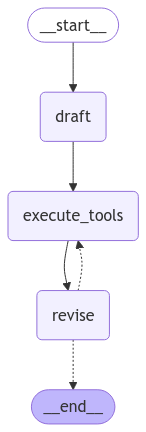

In [20]:
from IPython.display import Image, display

try:
    display(Image(sub_graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [21]:
events = sub_graph.stream(
    {"messages": [("user", "Who is the current chairman of TATA groups? What happened to the old one?")]},
    stream_mode="values",
)
for i, step in enumerate(events):
    print(f"Step {i}")
    step["messages"][-1].pretty_print()

Step 0
================================ Human Message =================================

Who is the current chairman of TATA groups? What happened to the old one?
Step 1
================================== Ai Message ==================================
Tool Calls:
  AnswerQuestion (call_BfxkchXXMvqTpiCeCAHsLTEC)
 Call ID: call_BfxkchXXMvqTpiCeCAHsLTEC
  Args:
    answer: As of now, the current chairman of Tata Sons, the holding company of the Tata Group, is Natarajan Chandrasekaran. He has held the position since February 2017. Chandrasekaran, who previously served as the CEO and Managing Director of Tata Consultancy Services (TCS), was appointed as the chairman following the ousting of the former chairman, Cyrus Mistry, in October 2016.

Cyrus Mistry's removal was surrounded by controversy and legal battles, primarily stemming from disagreements with the Tata family and the board regarding the direction of the group. Following his removal, Mistry contested the decision in court, arguing

In [22]:
# Finding Notes assistant
from langchain_core.messages import AIMessage

def research_stock(state: State, config: RunnableConfig):
    user_query = state["messages"][-1].content
    response = sub_graph.invoke({"messages": [("user", user_query)]})

    formatted_response = f"""
Answer:
{response["messages"][-1].tool_calls[0]['args']['answer']}
"""
    if('references' in response["messages"][-1].tool_calls[0]['args']):
        formatted_response+=f"""References:
{response["messages"][-1].tool_calls[0]['args']['references']}"""
    return {"messages": [AIMessage(content = formatted_response)]}

builder.add_node(
    "enter_research_stock_news",
    create_entry_node("Stock Researcher Assistant", "research_stock_news"),
)
builder.add_node("research_stock_news", research_stock)
builder.add_edge("enter_research_stock_news","research_stock_news")
builder.add_edge("research_stock_news", "leave_skill")

In [23]:
# Primary assistant
builder.add_node("primary_assistant", Assistant(assistant_runnable))
builder.add_node(
    "primary_assistant_tools", create_tool_node_with_fallback(primary_assistant_tools)
)

def route_primary_assistant(
    state: State,
):
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    if tool_calls:
        if tool_calls[0]["name"] == AddTransactionAssistant.__name__:
            return "enter_add_transactions"
        elif tool_calls[0]["name"] == RetrieveTransactions.__name__:
            return "enter_retrieve_transactions"
        elif tool_calls[0]["name"] == RetrieveNotes.__name__:
            return "enter_find_notes"
        elif tool_calls[0]["name"] == StockResearcher.__name__:
            return "enter_research_stock_news"
        return "primary_assistant_tools"
    raise ValueError("Invalid route")


# The assistant can route to one of the delegated assistants,
# directly use a tool, or directly respond to the user
builder.add_conditional_edges(
    "primary_assistant",
    route_primary_assistant,
    [
        "enter_add_transactions",
        "enter_retrieve_transactions",
        "enter_find_notes",
        "enter_research_stock_news",
        "primary_assistant_tools",
        END,
    ],
)
builder.add_edge("primary_assistant_tools", "primary_assistant")


# Each delegated workflow can directly respond to the user
# When the user responds, we want to return to the currently active workflow
def route_to_workflow(
    state: State,
) -> Literal[
    "primary_assistant",
    "add_transactions",
    "retrieve_transactions",
    "find_notes",
]:
    """If we are in a delegated state, route directly to the appropriate assistant."""
    dialog_state = state.get("dialog_state")
    if not dialog_state:
        return "primary_assistant"
    return dialog_state[-1]


builder.add_conditional_edges(START, route_to_workflow)

# Compile graph
memory = MemorySaver()
part_4_graph = builder.compile(
    checkpointer=memory,
    # Let the user approve or deny the use of sensitive tools
)

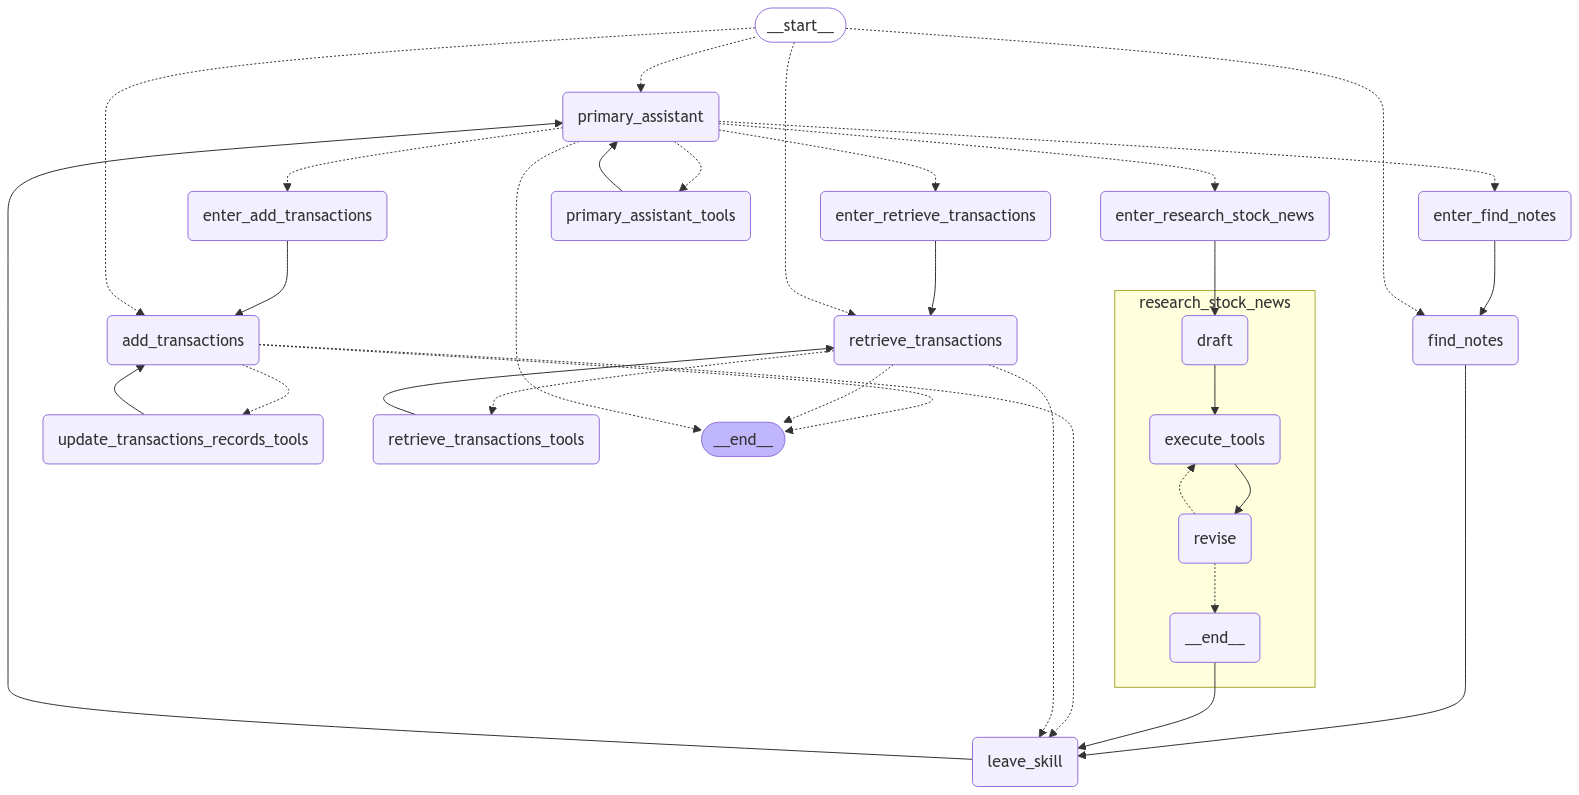

In [24]:
from IPython.display import Image, display

try:
    display(Image(part_4_graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [25]:
def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print("Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

In [26]:
import shutil
import uuid

thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

_printed = set()
while(True):
    question = input('Enter your question:')
    if(question=='exit'):
        break
    events = part_4_graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values", #subgraphs=True
    )
    for event in events:
        _print_event(event, _printed)


Enter your question: What is my costliest buy of all time?


================================ Human Message =================================

What is my costliest buy of all time?
================================== Ai Message ==================================
Tool Calls:
  RetrieveTransactions (call_rlgLQP8vCqE0EA6BQLEvYY0F)
 Call ID: call_rlgLQP8vCqE0EA6BQLEvYY0F
  Args:
    request: Find the costliest stock purchase made by the user.
Currently in:  retrieve_transactions
================================= Tool Message =================================

The assistant is now the Transactions Analysis Assistant. Reflect on the above conversation between the host assistant and the user. The user's intent is unsatisfied. Use the provided tools to assist the user. Remember, you are Transactions Analysis Assistant, and the stock transaction, analysis, other other action is not complete until after you have successfully invoked the appropriate tool. If the user changes their mind or needs help for other tasks, call the CompleteOrEscalate function to l

Enter your question: Give me a detailed report of the latest news of this company?


Currently in:  retrieve_transactions
================================ Human Message =================================

Give me a detailed report of the latest news of this company?
Currently in:  retrieve_transactions
================================== Ai Message ==================================
Tool Calls:
  CompleteOrEscalate (call_SX1qsglzPvr7GJ72rDpyftot)
 Call ID: call_SX1qsglzPvr7GJ72rDpyftot
  Args:
    reason: The requested detail about the latest news of Tata Consultancy Services is not available in the current database.
================================= Tool Message =================================

Resuming dialog with the host assistant. Please reflect on the past conversation and assist the user as needed.
================================== Ai Message ==================================
Tool Calls:
  StockResearcher (call_EJKfxuRG9rA7qovsQTfgfoD4)
 Call ID: call_EJKfxuRG9rA7qovsQTfgfoD4
  Args:
    request: latest news about Tata Consultancy Services
Currently in:  resea

Enter your question: exit
